# Learning Canonical Transformations from Trajectories of an Integrable Model

## Neumann Hamiltonian

We consider the integrable Hamiltonian

$$
H = \frac{1}{4}\sum_{\alpha,\beta} J_{\alpha\beta}^2 + \frac{1}{2}\sum_\alpha k_\alpha x_\alpha^2
$$

with $J_\alpha\beta = x_\alpha p_\beta - x_\beta p_\alpha$ is the (generalized) angular momentum. The constants of motion are

$$
I_\alpha = x_\alpha^2 + \sum_{\beta\neq \alpha} \frac{J_{\alpha\beta}^2}{k_\alpha-k_\beta}
$$

for $k_\alpha$ all different. We have

$$
H = \frac{1}{2}\sum_\alpha k_\alpha I_\alpha
$$

And

$$
\sum_\alpha x_\alpha^2 = \sum_\alpha I_\alpha,
$$

so that motion is confined to the sphere $S^{N-1}$.

## Equations of Motion

The equations of motion have Hamiltonian form

$$
\begin{align}
\dot p_\alpha &= \frac{\partial H}{\partial x_\alpha} = -k_\alpha x_\alpha-\sum_\beta \left[x_\alpha p_\beta-x_\beta p_\alpha\right]p_\beta\\
\dot x_\alpha &= -\frac{\partial H}{\partial p_\alpha} = \sum_\beta \left[p_\alpha x_\beta-p_\beta x_\alpha\right]x_\beta
\end{align}
$$

## Sample solution in TF

In [1]:
import sys
sys.path.append("../")
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

In [2]:
from hamiltonians import parameterized_neumann
from models import NICE, SymplecticExchange, SqueezeAndShift, Chain, MLP
from utils import visualize_chain_bijector_1d, extract_q_p

In [3]:
# tf.enable_eager_execution()
sess = tf.InteractiveSession()
tf.set_random_seed(0)

In [4]:
N = 3 
ks = np.random.rand(N)
ks = np.asfarray(ks, np.float32)
ks_tensor = tf.constant(ks, dtype=tf.float32, name="ks")

In [5]:
def join_q_p(qs, ps):
    qs = tf.expand_dims(qs, axis=1)
    ps = tf.expand_dims(ps, axis=1)
    return tf.reshape(tf.concat([qs,ps], axis=1), [-1])

In [6]:
def neumann_system(ks):
    def neumann_equations(phase_space_point, t):
        xs, ps = phase_space_point[::2], phase_space_point[1::2]
        dps = - ks * xs
        dps += -xs * tf.reduce_sum(ps**2)
        dps += ps * tf.reduce_sum(xs * ps)
        dxs = ps * tf.reduce_sum(xs**2)
        dxs += - xs * tf.reduce_sum(xs * ps)
        return join_q_p(dxs, dps)
    return neumann_equations

In [7]:
def neumann_batch(ks, size):
    N = ks.shape.as_list()[0]
    init_state = tf.random_uniform([2*N])
    t = tf.linspace(0.0, 100.0, num=size)
    tensor_state, tensor_info = tf.contrib.integrate.odeint(neumann_system(ks), init_state, t, full_output=True)
    return tensor_state

In [8]:
state = sess.run(neumann_batch(ks_tensor, 200))
x, px, y, py, z, pz = state.T

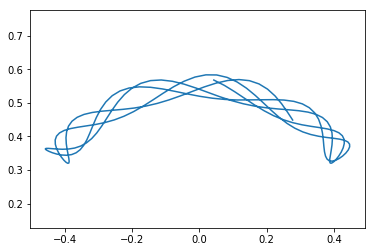

In [9]:
plt.axes().set_aspect('equal', 'datalim')
plt.plot(x, y)

## Check the integrals of motion

In [10]:
def Is(phase_space_point):
    xs, ps = phase_space_point[::2], phase_space_point[1::2]
    Is = xs**2 
    for α, _ in enumerate(Is):
        for β, _ in enumerate(Is):
            J = xs[α]*ps[β] - ps[α]*xs[β]
            if β != α:
                Is[α] += J**2 / (ks[α] - ks[β])
    return Is

In [11]:
I_traj = np.array([Is(point) for point in state])

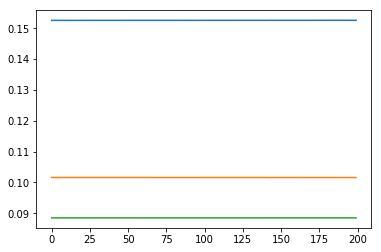

In [12]:
plt.plot(I_traj)

Check the imlementation of the Neumann Hamiltonian yields correct value

In [13]:
neumann_hamiltonian = parameterized_neumann(ks_tensor)

In [14]:
init_state = tf.random_uniform([2*N])
sess.run(neumann_hamiltonian(tf.reshape(init_state, (1,-1,1))))

array([[[0.30139446]]], dtype=float32)

In [15]:
np.sum(ks*Is(sess.run(init_state))) / 2

0.6476019620895386

## Learning a Transformation

The idea is to map _from_ trajectories _to_ the phase plane of action angle variables, imposing the condition that the distribution factorizes.

In [16]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [17]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': parameterized_neumann(ks), 
    'phase_space_dim': 2*N, 
    'batch_size': 256,    # Mini batch size 
    'num_bijectors': 4,   # Number of bijectors
    'train_iters': 1e5}   # Number of training iterations

Here we try modeling the derivative of the generating function directly

In [18]:
with tf.variable_scope("transform"):
    bijectors = [SqueezeAndShift(shift_model=MLP(return_gradient=False,activation=tf.nn.relu)) if i % 2 == 0 
             else SymplecticExchange() 
             for i in range(settings['num_bijectors'])]
    model = Chain(bijectors)

The temperatures of the GGE distributions must be learned, but we must ensure they are positive

In [19]:
sqrt_betas = tf.get_variable("betas", shape=[1,N,1], dtype=DTYPE)
sqrt_betas_doubled = tf.tile(sqrt_betas, [1,1,2])

Accounting for the normalization, the log probability is

$$
\log p = -\sum_j \left(\beta_j \left[q_j^2+p_j^2\right)-\frac{1}{2}\log (\beta_j/\pi)\right)
$$

In [20]:
with tf.variable_scope("loss"):
    z_samples = tf.expand_dims(neumann_batch(ks_tensor, settings['batch_size']), -1)
    q, p = extract_q_p(model(z_samples))
    z_doubled = tf.concat([q, p], 2)
    z_doubled *= sqrt_betas_doubled**2
    loss = tf.reduce_mean(tf.square(z_doubled) - tf.log(sqrt_betas_doubled**2) / 2)

In [21]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step=step)

Add some summaries for tracking with TensorBoard

In [22]:
tf.summary.scalar("loss_function", tf.reshape(loss, []))

<tf.Tensor 'loss_function:0' shape=() dtype=string>

In [31]:
tf.contrib.training.train(train_op, logdir="../logging", save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../logging/model.ckpt-1291
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1291 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.40496
INFO:tensorflow:Saving checkpoints for 1435 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.3882
INFO:tensorflow:Saving checkpoints for 1580 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.42212
INFO:tensorflow:global_step/sec: 2.32126
INFO:tensorflow:Saving checkpoints for 1720 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.43094
INFO:tensorflow:Saving checkpoints for 1865 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.40088
INFO:tensorflow:global_step/sec: 2.205
INFO:tensorflow:Saving checkpoints for 2002 into ../logging/model.ckpt.


KeyboardInterrupt: 

## Look at the Learned Representation

Load the saved model

In [25]:
saver = tf.train.Saver()

In [32]:
saver.restore(sess, "../logging/model.ckpt-2002")

INFO:tensorflow:Restoring parameters from ../logging/model.ckpt-2002


How do the trajectories look in the phase planes of the new variables?

In [33]:
transformed_traj = sess.run(model(z_samples))[:,:,0]
x1, y1, x2, y2, x3, y3 = transformed_traj.T

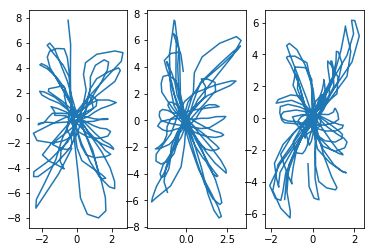

In [34]:
plt.subplot(1, 3, 1)
plt.plot(x1, y1)

plt.subplot(1, 3, 2)
plt.plot(x2, y2)

plt.subplot(1, 3, 3)
plt.plot(x3, y3)